In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm
import pickle

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]

In [3]:
experiment_id_idx = 0
experiment_id = experiment_ids[experiment_id_idx]

In [4]:
model = torch.load(f'saved/{experiment_id}.pt', weights_only=False, map_location='cpu')

In [110]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)
L = 45
q = 4

In [111]:
def hamming(x, y):
    L = x.size(-1)
    return (x != y).sum(dim=(-1))

In [ ]:
import itertools

In [146]:
d = 1

sites = [str(i) for i in range(L)]
letters = [str(i) for i in range(1, q)]
iter_letters = itertools.combinations_with_replacement(sites, d)
iter_sites = itertools.combinations_with_replacement(letters, a)

seq = []

for sites in iter_sites:
    delta = torch.zeros(L)
    for letters in iter_letters:
        delta[sites] = torch.IntTensor(letters)
        s = torch.fmod(delta+wt, q)
        seq.append(s)
neighbors = torch.stack(seq).to(dtype=torch.int)

ValueError: too many dimensions 'str'

In [147]:
sites = next(iter_sites)

In [ ]:
seq = []
for i in range(L):
    delta = torch.zeros(L)
    # use itertools.product here to generalize to distance d
    for a in range(1, q):
        delta[i] = a
        s = torch.fmod(delta+wt, q)
        seq.append(s)
neighbors = torch.stack(seq).to(dtype=torch.int)

In [112]:
seq = []
for i in range(L):
    delta = torch.zeros(L)
    # use itertools.product here to generalize to distance d
    for a in range(1, q):
        delta[i] = a
        s = torch.fmod(delta+wt, q)
        seq.append(s)
neighbors = torch.stack(seq).to(dtype=torch.int)

In [113]:
neighbors_oh = utils.one_hot(neighbors)

In [118]:
logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()

In [119]:
logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()

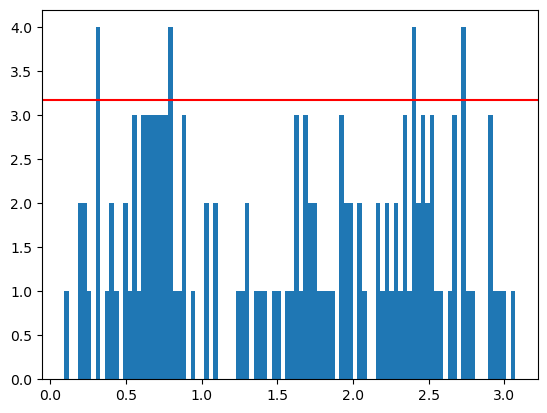

In [124]:
fig, ax = plt.subplots()
ax.hist(logps_neigs, bins=100)
ax.axhline(y=logps_wt.item(), color='red')